In [ ]:
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from matplotlib.patches import Arc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
def pre_processing(path):

    '''
        pre_processing:

                Param  : 
                    path : Path for the image to processed.

                Return :
                    edge_image : NumpyArray that stores the grayscale values of 
                                 Input image.
    '''

    image = cv2.imread(path)

    image = cv2.bitwise_not(image)

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # print("Gray:",gray,"\n")
    # plt.imshow(gray,cmap='gray')
    # plt.show()

    blur = cv2.GaussianBlur(gray,(5,5),0)

    # print("blur:",blur,"\n")
    # plt.imshow(blur,cmap='gray')
    # plt.show()

    ret,thresh = cv2.threshold(blur,50,255,cv2.THRESH_BINARY)
    # thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,
    #         cv2.THRESH_BINARY,13,1)
    

    return thresh

In [ ]:
def filter_threshold(indexes,filter_indexes,filt_rho = 20,filt_theta= 0.2):

    '''
        Filter_threshold:

            Param:
                indexes :  The raw [rho,theta] values with duplicates for same line.
                filter_indexes : A list to store indexes of unique lines.
                filt_rho : acceptable rho ranges to group lines.
                filt_theta  : acceptable theta ranges to group lines.

            Return :  
                filter_indexes : Dataset that stores filtered(duplicate values) 
                                 (rho,theta) values.
    '''
    a = 0

    rho = indexes[a][0]
    theta = indexes[a][1]
    unfilt_indexes = []
    unfilt_values = []

    for j in range(len(indexes)):

        
        if rho<0:
            rho *= -1
            theta -= np.pi

        curr_rho = indexes[j][0]
        curr_theta = indexes[j][1]

        if curr_rho<0:
            curr_rho *= -1
            curr_theta -= np.pi

        if a == j:
            pass
        elif ( 0 <= abs(curr_rho-rho) <filt_rho) and (0<= abs(curr_theta-theta)<filt_theta):

            pass

        else:
            unfilt_indexes.append([curr_rho,curr_theta])

    filter_indexes.append([rho,theta])

    if len(unfilt_indexes)>0:
        x = filter_threshold(unfilt_indexes,filter_indexes)

    return filter_indexes

In [ ]:
def calc_coord(datas):

    '''
        calc_coord : 
            
            Param:
                datas: [rho,theta] values (preferably after filtering)

            Return:
                co_ord : List with lines stored as two point form in format 
                        (x1,y1,x2,y2)
    '''

    co_ord = []

    for rho,theta in datas:
        a = np.cos(theta)
        b = np.sin(theta)
        x = rho*a
        y = rho*b
        x1 = int(x+1000*(-b))
        y1 = int(y+1000*(a))
        x2 = int(x-1000*(-b))
        y2 = int(y-1000*(a))
        co_ord.append([x1,y1,x2,y2])
    
    return co_ord


In [ ]:
def plot_line(path,datas,mode = 1):

    '''
        plot_line :

            Param:
                path  : Image to plot lines on
                datas : Dataset  with line stored in two point form (x1,y1,x2,y2)
                mode  : 1) For plotting line on image mode = 1(default)
                        2) for plotting line without image mode =2

            Return :
                plot image
            
    '''

    Image = cv2.imread(path)

    if mode == 1:

        for i in range(len(datas)):

            x1,y1,x2,y2 = datas[i]
            cv2.line(Image,(x1,y1),(x2,y2),(0,0,255),2)
        
        plt.imshow(Image)
        # plt.gca().invert_yaxis()
        plt.show()
    
    elif mode == 2:

        for i in range(len(datas)):
            plt.gca().invert_yaxis()
            plt.plot([datas[i][0],datas[i][2]],[datas[i][1],datas[i][3]],'-g')

    else:

        print("Mode : \n 1) Pot line with Image \n 2) Plot line without image")

In [ ]:
def slope_angle(datas):

    '''
        slope_angle:

            Param:
                datas: Dataset with co-ordinates of lines (x1,y1,x2,y2)

            Return:
                slopes : slopes of lines (m)
                angles :  angles of line w.r.t x axis.
    '''

    slopes = []
    angles = []

    for i in range(len(datas)):

        x1,y1,x2,y2 = datas[i]
        slopes.append(np.divide(y2-y1,x2-x1))
        angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
        angles.append(angle)
    
    return slopes,angles

In [ ]:
def filter_hv(datas,angles):

    '''
        filter_hv:

            Param:
                datas : Dataset with  co-ordinates of line (x1,y1,x2,y2)
                angles: Angles of the corresponding line in the dataset

            Return:
                valid:  Dataset with co-ordinates of lines that are not 
                        Horizontal or Vertical.
    '''

    valid  = []
    angles_valid = []
    for i in range(len(angles)):

        if -83 < angles[i]< 83 :
            if  int(angles[i]) not in range(-5,6):
                valid.append(datas[i])
                angles_valid.append(angles[i])

                
    return valid,angles_valid


In [ ]:
def calc_coeff(datas):

    '''
        calc_coeff:

            Param:
                datas: Dataset of lines in (x1,y1,x2,y2) format.(Filtered).

            Return:
                coeff: Return a,b,c coefficients of each pair of lines.
                        [[a1,b1,c1],[a2,b2,c2]].
    '''

    coeff = np.zeros((len(datas),len(datas)),dtype= object)

    for i in range(len(datas)):
        for j in range(i+1,len(datas)):

            x1,y1,x2,y2 = datas[i]
            x3,y3,x4,y4 = datas[j]
            a1,a2 = y2-y1 , y4-y3
            b1,b2 = x1-x2 , x3-x4
            c1,c2 = y1*x2 - x1*y2 , y3*x4 - x3*y4 

            coeff[i][j] = ([a1,b1,c1],[a2,b2,c2])

    return coeff

In [ ]:
def intersection(datas):

    '''
        intersection:
                    
            Param:
                datas: Dataset with coefficients of line.
                
            Return:
                inter: Dataset with intersection points for each pair of lines.
    '''

    inter = np.zeros_like(datas,dtype=object)

    for i in range(len(datas)):
        for j in range(i+1,len(datas)):

            a1,b1,c1 = datas[i][j][0]
            a2,b2,c2 = datas[i][j][1]

            x = np.divide((b1*c2)-(b2*c1),(a1*b2)-(a2*b1))
            y = np.divide((a2*c1)-(a1*c2),(a1*b2)-(a2*b1))

            inter[i][j] = (x,y)

    return inter


In [ ]:
def clustering(datas,persp):
    
    '''
        clustering:

                Param :
                        datas: Dataset with intersection points of lines.
                        persp: Point perspective of cube . (1,2,3)

                Return :
                        l : Dataset  with output of kmeans clustering that divides
                            the points in (persp) groups.
    '''
    # Inter dataset is currently in different format. Kmeans requires
    # equal number of x and y vlue so,  ([x1,y1],[x2,y2],[x3,y3])

    x = []
    for i in range(len(inter)):
        for j in range(len(inter[i])):
                if inter[i][j] != 0:
                        x.append([inter[i][j][0],inter[i][j][1]])
    
    # persp+1 is because perspective indicates how many vanishing points are
    # and +1 group for the random lines detected.
    print(x)
    kmeans = KMeans(n_clusters=persp+1,random_state=0).fit(x)
    l = kmeans.predict(x)


    return l

In [ ]:
def angle_by_slope(datas,line1,line2):

    '''
    angle_by_angle:

            Param :
                    datas: Slopes of line in Radians.
                    line1: Index or Line no. of first line.
                    line2: Index or Line no. of  second line.
            Return:
                    angle:  angle between two lines by using three points.
                            points :- (x,y) on line 1 , (x,y) on line 2 , (x,y) intersection
                            of lines
    '''

    m1,m2 = datas[line1],datas[line2]
    l = (m2 - m1 ) / (1+m1*m2)
    angle = np.arctan(l)*(180/np.pi)

    return angle

In [ ]:
def convert_angle(datas):

    '''
        Param : 
                datas: angles on the range 90 to -90
        
        Return : 
                angle_360 : angles ranging from 0 to 360

        Note :  Changing the angles from -90 to 360 messes with the 
                filter_hv function.
    '''

    

    angle_360 = []
    for i in datas:
        
        if i<0:
            i += 2*180
        angle_360.append(i)

    return angle_360

In [ ]:
# def get_angle_text(angle_plot,line1,line2):

#     angle = angle_plot.get_label()[:-1] # Excluding the degree symbol
#     angle = "%0.2f"%float(angle)+u"\u00b0" # Display angle upto 2 decimal places

#     x,y = inter[line1][line2]

#     return [x-20,y-50, angle]

In [ ]:
# def plot_arc(angle_360,valid,inter,x_val,y_val):

#     '''
#         Plot_arc:
#             param:

#                 angle_360 : Angles in the range (0,2𝜋).
#                 valid : Co-ordinates for lines after filtering.
#                 inter: Intersection points for the center of arc.
#                 axes_val : Axes lim for plotting.

#             Return:  
#                     Plot the graph.
#                     0
#     '''
#     fig, ax = plt.subplots()

#     # For debugging
#     # angle_plot = []
#     # outer_angle = []


#     for i in range(len(angle_360)):
#         for j in range(i+1,len(angle_360)):

#             # Getting indexes for the two lines
#             line1,line2 = i,j

#             # Theta1 is the smaller angle and theta2 is the larger angle.
#             theta1 = min(angle_360[i],angle_360[j])
#             theta2 = max(angle_360[i],angle_360[j])

#             # Converting theta in range (0,2pi) to (-180,180).
#             if theta2>180:
#                 theta2 = theta2 -  180

#             # Calculating the inner angle of intersection.
#             angle = (theta2-theta1)

#             # Converting obtuse angles to acute angles.
#             if angle>90:
#                 angle = 180-angle
#             elif angle<0:
#                 angle = 180+angle

#             x1,y1,x2,y2 = valid[line1]
#             x3,y3,x4,y4 = valid[line2]
            
#             # Creating arc object
#             angle_p = Arc((inter[line1][line2]),50,50,0, theta1+theta2,theta2+theta2, color='green', label = str(angle)+u"\u00b0")
            
#             # For debugging        
#             # outer_angle.append(theta2-theta1)
#             # angle_plot.append(angle_p)

#             # Storing respective lines into line object for plotting.
#             linea = Line2D([x1,x2], [y1,y2], linewidth=1, linestyle = "-", color="green")
#             lineb = Line2D([x3,x4], [y3,y4], linewidth=1, linestyle = "-", color="red")
            
#             # Angle text function returns angle angle value and intersection point.
#             angle_text = get_angle_text(angle_p,line1,line2)

#             # Axes to plot lines
#             ax.add_line(linea)
#             ax.add_line(lineb)
#             ax.add_patch(angle_p)
#             ax.text(*angle_text)

#     # Declaring range for the ordinate and abcissa.`
#     ax.set_xlim(x_val[0],x_val[1])
#     ax.set_ylim(y_val[0],y_val[1])

#     # For inverting the y-axis
#     ax.set_ylim(ax.get_ylim()[::-1])

#     return 0

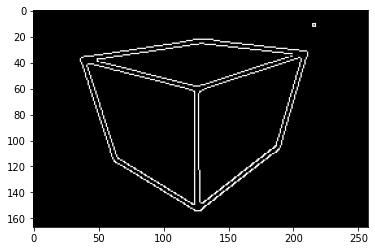

In [ ]:
path = "/work/cubes/8.jpg"

thresh = pre_processing(path)

canny = cv2.Canny(thresh,100,200)
plt.imshow(canny,cmap='gray')
plt.show()

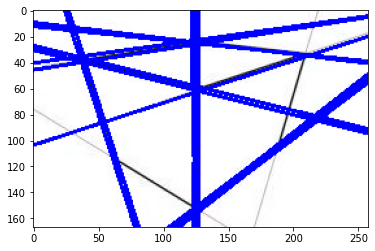

In [ ]:
hough_threshold = 60
lines = cv2.HoughLines(canny,1,(np.pi/180),hough_threshold)

lines = lines.squeeze()

plot_line(path,calc_coord(lines),1)

6


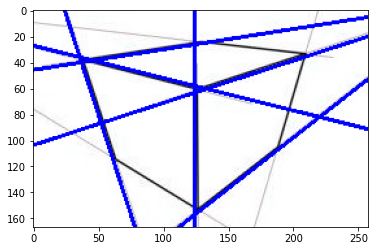

In [ ]:
filtered_indexes = []
filtered_indexes = filter_threshold(lines,filtered_indexes,40,0.3)

co_ord = calc_coord(filtered_indexes)
print(len(co_ord))

plot_line(path,co_ord,1)

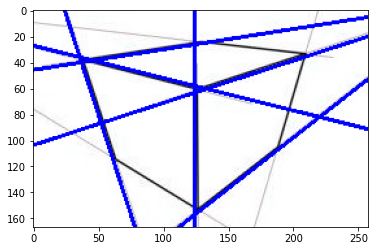

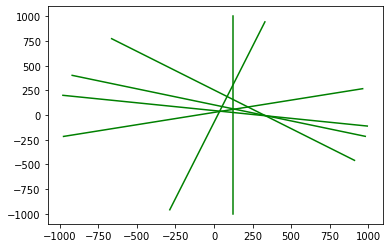

In [ ]:
plot_line(path,co_ord,1)
plot_line(path,co_ord,2)

In [ ]:
# For filtering horizonal and vertical lines.

# slopes,angles = slope_angle(co_ord)

# valid,angles_valid  = filter_hv(co_ord,angles)

In [ ]:
#To calculate intersection points.

coeff = calc_coeff(co_ord)

inter = intersection(coeff)

In [ ]:
l = []
positions = []
for i in range(len(inter)):
    for j in range(len(inter[i])):
        if inter[i][j] !=0:
            l.append(inter[i][j])
            positions.append([i,j])
        else:
            l.append((0,0))
            positions.append([i,j])

kmeans = KMeans(n_clusters=6,random_state=0).fit(l)
groups = kmeans.predict(l)

In [ ]:
proximity  = {}
for i in range(len(groups)):
    if groups[i] in proximity.keys():
        proximity[groups[i]].append(positions[i][0])
        proximity[groups[i]].append(positions[i][1])
    else:
        proximity[groups[i]] = [positions[i][0],positions[i][1]]

In [ ]:
plot_group = []

for key in proximity.keys():

    count = {}
    for i in proximity[key]:
        if i in count.keys():
            count[i] += 1
        else:
            count[i] = 1
    temp = []  
    for k,v in count.items():
        if v>1:
            temp.append(k)

    if len(temp) >3:
        plot_group.append(temp)
    proximity[key] = temp

0


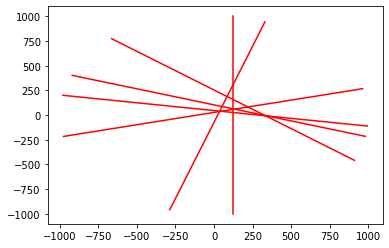

In [ ]:
colors = ['r', 'g', 'b', 'y']
style = ['-', '--', ':', '-.']
k = 0
for j in plot_group:
    print(k)
    for i in j:
        plt.plot([co_ord[i][0],co_ord[i][2]],[co_ord[i][1],co_ord[i][3]],colors[k]+style[k])
    k += 1 
    # plt.xlim([-250,450])
    # plt.ylim([-150,350])        

# Experimenting

In [ ]:
# angle_360 = convert_angle(angles)
# plot_arc(angle_360,co_ord,inter,(-300,500),(-300,500))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8a44a380-3932-4441-acdf-31a0d8f692bc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>